<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout



### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# Descargar la carpeta de dataset
from google.colab import drive
drive.mount('/content/drive')
df= pd.read_excel('/content/drive/MyDrive/Colab Notebooks/df_noticias.xlsx')


#quitar límite de columnas:
pd.options.display.max_columns = None

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df.head()

,ArticleId,Texto,Categoría
0,1833,worldcom ex-jefe de lanza de la defensa de los...,negocio
1,154,alemán de confianza empresarial diapositivas a...,negocio
2,1101,bbc encuesta indica pesimismo económico de los...,negocio
3,1976,estilo de vida que rige la elección de disposi...,tecnologia
4,917,enron jefes en fue de $168 millones de pago de...,negocio


In [4]:
df.shape

(1580, 3)

In [5]:
df = df.sample(frac=0.1)

In [6]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 158


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [7]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [8]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.iloc[0]['Texto']
text

"arnesen niega ruptura con santini, director deportivo del tottenham frank arnesen, ha negado que el entrenador jacques santini dimitido a causa de un choque de personalidades en white hart lane.\xa0había sido el periódico de la especulación de que santini había sentido socavada por arnesen s papel en el club.\xa0esto no es absolutamente cierto arnesen, dijo a bbc radio five live.\xa0sólo hay una cosa que le hizo renunciar y que es, sus propios problemas personales.\xa0él ha hablado a mí recientemente y dijo que este asunto es absolutamente para sí mismo.\xa0arnesen dijo que él era incapaz de arrojar luz sobre los problemas que causaron santini para salir después de sólo 13 juegos en el cargo.\xa0añadió: jacques nunca ha pasado exactamente lo que era.\xa0pero yo confío en él, en que; usted tiene que aceptarlo.\xa0creo que debemos respetar.\xa0el plan es que durante el fin de semana vamos a tener conversaciones con la junta directiva y, a continuación, el lunes vamos a aclarar la situac

In [9]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['arnesen',
 'niega',
 'ruptura',
 'con',
 'santini',
 'director',
 'deportivo',
 'del',
 'tottenham',
 'frank',
 'arnesen',
 'ha',
 'negado',
 'que',
 'el',
 'entrenador',
 'jacques',
 'santini',
 'dimitido',
 'a',
 'causa',
 'de',
 'un',
 'choque',
 'de',
 'personalidades',
 'en',
 'white',
 'hart',
 'lane',
 '\xa0había',
 'sido',
 'el',
 'periódico',
 'de',
 'la',
 'especulación',
 'de',
 'que',
 'santini',
 'había',
 'sentido',
 'socavada',
 'por',
 'arnesen',
 's',
 'papel',
 'en',
 'el',
 'club',
 '\xa0esto',
 'no',
 'es',
 'absolutamente',
 'cierto',
 'arnesen',
 'dijo',
 'a',
 'bbc',
 'radio',
 'five',
 'live',
 '\xa0sólo',
 'hay',
 'una',
 'cosa',
 'que',
 'le',
 'hizo',
 'renunciar',
 'y',
 'que',
 'es',
 'sus',
 'propios',
 'problemas',
 'personales',
 '\xa0él',
 'ha',
 'hablado',
 'a',
 'mí',
 'recientemente',
 'y',
 'dijo',
 'que',
 'este',
 'asunto',
 'es',
 'absolutamente',
 'para',
 'sí',
 'mismo',
 '\xa0arnesen',
 'dijo',
 'que',
 'él',
 'era',
 'incapaz',
 'de',
 'arr

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [10]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row["Texto"]))

In [11]:
# Demos un vistazo
sentence_tokens[:2]

[['arnesen',
  'niega',
  'ruptura',
  'con',
  'santini',
  'director',
  'deportivo',
  'del',
  'tottenham',
  'frank',
  'arnesen',
  'ha',
  'negado',
  'que',
  'el',
  'entrenador',
  'jacques',
  'santini',
  'dimitido',
  'a',
  'causa',
  'de',
  'un',
  'choque',
  'de',
  'personalidades',
  'en',
  'white',
  'hart',
  'lane',
  '\xa0había',
  'sido',
  'el',
  'periódico',
  'de',
  'la',
  'especulación',
  'de',
  'que',
  'santini',
  'había',
  'sentido',
  'socavada',
  'por',
  'arnesen',
  's',
  'papel',
  'en',
  'el',
  'club',
  '\xa0esto',
  'no',
  'es',
  'absolutamente',
  'cierto',
  'arnesen',
  'dijo',
  'a',
  'bbc',
  'radio',
  'five',
  'live',
  '\xa0sólo',
  'hay',
  'una',
  'cosa',
  'que',
  'le',
  'hizo',
  'renunciar',
  'y',
  'que',
  'es',
  'sus',
  'propios',
  'problemas',
  'personales',
  '\xa0él',
  'ha',
  'hablado',
  'a',
  'mí',
  'recientemente',
  'y',
  'dijo',
  'que',
  'este',
  'asunto',
  'es',
  'absolutamente',
  'para'

In [12]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [13]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences

[['arnesen', 'niega', 'ruptura', 'con'],
 ['niega', 'ruptura', 'con', 'santini'],
 ['ruptura', 'con', 'santini', 'director'],
 ['con', 'santini', 'director', 'deportivo'],
 ['santini', 'director', 'deportivo', 'del'],
 ['director', 'deportivo', 'del', 'tottenham'],
 ['deportivo', 'del', 'tottenham', 'frank'],
 ['del', 'tottenham', 'frank', 'arnesen'],
 ['tottenham', 'frank', 'arnesen', 'ha'],
 ['frank', 'arnesen', 'ha', 'negado'],
 ['arnesen', 'ha', 'negado', 'que'],
 ['ha', 'negado', 'que', 'el'],
 ['negado', 'que', 'el', 'entrenador'],
 ['que', 'el', 'entrenador', 'jacques'],
 ['el', 'entrenador', 'jacques', 'santini'],
 ['entrenador', 'jacques', 'santini', 'dimitido'],
 ['jacques', 'santini', 'dimitido', 'a'],
 ['santini', 'dimitido', 'a', 'causa'],
 ['dimitido', 'a', 'causa', 'de'],
 ['a', 'causa', 'de', 'un'],
 ['causa', 'de', 'un', 'choque'],
 ['de', 'un', 'choque', 'de'],
 ['un', 'choque', 'de', 'personalidades'],
 ['choque', 'de', 'personalidades', 'en'],
 ['de', 'personalidade

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [14]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [15]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[13, 228, 59, 22],
 [228, 59, 22, 8],
 [59, 22, 8, 15],
 [22, 8, 15, 23],
 [8, 15, 23, 30],
 [15, 23, 30, 16],
 [23, 30, 16, 31],
 [30, 16, 31, 13],
 [16, 31, 13, 21],
 [31, 13, 21, 60],
 [13, 21, 60, 1],
 [21, 60, 1, 3],
 [60, 1, 3, 32],
 [1, 3, 32, 33],
 [3, 32, 33, 8],
 [32, 33, 8, 61],
 [33, 8, 61, 6],
 [8, 61, 6, 62],
 [61, 6, 62, 2],
 [6, 62, 2, 9],
 [62, 2, 9, 63],
 [2, 9, 63, 2],
 [9, 63, 2, 64],
 [63, 2, 64, 5],
 [2, 64, 5, 34],
 [64, 5, 34, 35],
 [5, 34, 35, 36],
 [34, 35, 36, 65],
 [35, 36, 65, 66],
 [36, 65, 66, 3],
 [65, 66, 3, 67],
 [66, 3, 67, 2],
 [3, 67, 2, 10],
 [67, 2, 10, 68],
 [2, 10, 68, 2],
 [10, 68, 2, 1],
 [68, 2, 1, 8],
 [2, 1, 8, 24],
 [1, 8, 24, 69],
 [8, 24, 69, 70],
 [24, 69, 70, 25],
 [69, 70, 25, 13],
 [70, 25, 13, 37],
 [25, 13, 37, 38],
 [13, 37, 38, 5],
 [37, 38, 5, 3],
 [38, 5, 3, 71],
 [5, 3, 71, 72],
 [3, 71, 72, 20],
 [71, 72, 20, 11],
 [72, 20, 11, 39],
 [20, 11, 39, 73],
 [11, 39, 73, 13],
 [39, 73, 13, 7],
 [73, 13, 7, 6],
 [13, 7, 6, 74],
 [7

In [16]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

432


In [17]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

228


In [18]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'que': 1, 'de': 2, 'el': 3, 'y': 4, 'en': 5, 'a': 6, 'dijo': 7, 'santini': 8, 'un': 9, 'la': 10, 'es': 11, 'los': 12, 'arnesen': 13, 'se': 14, 'director': 15, 'tottenham': 16, 'una': 17, 'problemas': 18, 'muy': 19, 'no': 20, 'ha': 21, 'con': 22, 'deportivo': 23, 'había': 24, 'por': 25, 'él': 26, '\xa0pero': 27, 'yo': 28, 'fue': 29, 'del': 30, 'frank': 31, 'entrenador': 32, 'jacques': 33, 'white': 34, 'hart': 35, 'lane': 36, 's': 37, 'papel': 38, 'absolutamente': 39, 'personales': 40, '\xa0él': 41, 'para': 42, '\xa0arnesen': 43, 'era': 44, 'sobre': 45, 'lo': 46, '\xa0creo': 47, '\xa0el': 48, 'vamos': 49, 'tener': 50, 'creo': 51, '\xa0que': 52, 'spurs': 53, 'estructura': 54, 'trabajar': 55, 'confianza': 56, 'stevens': 57, 'si': 58, 'ruptura': 59, 'negado': 60, 'dimitido': 61, 'causa': 62, 'choque': 63, 'personalidades': 64, '\xa0había': 65, 'sido': 66, 'periódico': 67, 'especulación': 68, 'sentido': 69, 'socavada': 70, 'club': 71, '\xa0esto': 72, 'cierto': 73, 'bbc': 74, 'radio': 75, 'f

In [19]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'ruptura': 7, 'niega': 2, 'con': 12, 'arnesen': 21, 'santini': 28, 'director': 16, 'deportivo': 12, 'del': 8, 'tottenham': 16, 'frank': 8, 'ha': 13, 'negado': 4, 'que': 108, 'el': 68, 'entrenador': 8, 'jacques': 8, 'dimitido': 4, 'a': 36, 'causa': 4, 'de': 93, 'un': 28, 'choque': 4, 'personalidades': 4, 'en': 42, 'white': 8, 'hart': 8, 'lane': 8, '\xa0había': 4, 'sido': 4, 'periódico': 4, 'la': 28, 'especulación': 4, 'había': 12, 'sentido': 4, 'socavada': 4, 'por': 12, 's': 8, 'papel': 8, 'club': 4, '\xa0esto': 4, 'no': 14, 'es': 24, 'absolutamente': 8, 'cierto': 4, 'dijo': 36, 'bbc': 4, 'radio': 4, 'five': 4, 'live': 4, '\xa0sólo': 4, 'hay': 4, 'una': 16, 'cosa': 4, 'le': 4, 'hizo': 4, 'renunciar': 4, 'y': 48, 'sus': 4, 'propios': 4, 'problemas': 16, 'personales': 8, '\xa0él': 8, 'hablado': 4, 'mí': 4, 'recientemente': 4, 'este': 4, 'asunto': 4, 'para': 8, 'sí': 4, 'mismo': 4, '\xa0arnesen': 8, 'él': 12, 'era': 8, 'incapaz': 4, 'arrojar': 4, 'luz': 4, 'sobr

### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [20]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.iloc[0]['Texto']
text

"arnesen niega ruptura con santini, director deportivo del tottenham frank arnesen, ha negado que el entrenador jacques santini dimitido a causa de un choque de personalidades en white hart lane.\xa0había sido el periódico de la especulación de que santini había sentido socavada por arnesen s papel en el club.\xa0esto no es absolutamente cierto arnesen, dijo a bbc radio five live.\xa0sólo hay una cosa que le hizo renunciar y que es, sus propios problemas personales.\xa0él ha hablado a mí recientemente y dijo que este asunto es absolutamente para sí mismo.\xa0arnesen dijo que él era incapaz de arrojar luz sobre los problemas que causaron santini para salir después de sólo 13 juegos en el cargo.\xa0añadió: jacques nunca ha pasado exactamente lo que era.\xa0pero yo confío en él, en que; usted tiene que aceptarlo.\xa0creo que debemos respetar.\xa0el plan es que durante el fin de semana vamos a tener conversaciones con la junta directiva y, a continuación, el lunes vamos a aclarar la situac

In [21]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)["Texto"]
corpus

'arnesen niega ruptura con santini, director deportivo del tottenham frank arnesen, ha negado que el entrenador jacques santini dimitido a causa de un choque de personalidades en white hart lane.\xa0había sido el periódico de la especulación de que santini había sentido socavada por arnesen s papel en el club.\xa0esto no es absolutamente cierto arnesen, dijo a bbc radio five live.\xa0sólo hay una cosa que le hizo renunciar y que es, sus propios problemas personales.\xa0él ha hablado a mí recientemente y dijo que este asunto es absolutamente para sí mismo.\xa0arnesen dijo que él era incapaz de arrojar luz sobre los problemas que causaron santini para salir después de sólo 13 juegos en el cargo.\xa0añadió: jacques nunca ha pasado exactamente lo que era.\xa0pero yo confío en él, en que; usted tiene que aceptarlo.\xa0creo que debemos respetar.\xa0el plan es que durante el fin de semana vamos a tener conversaciones con la junta directiva y, a continuación, el lunes vamos a aclarar la situac

In [22]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['arnesen',
 'niega',
 'ruptura',
 'con',
 'santini',
 'director',
 'deportivo',
 'del',
 'tottenham',
 'frank',
 'arnesen',
 'ha',
 'negado',
 'que',
 'el',
 'entrenador',
 'jacques',
 'santini',
 'dimitido',
 'a']

In [23]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 74112


In [24]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [25]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['arnesen', 'niega', 'ruptura', 'con'],
 ['niega', 'ruptura', 'con', 'santini'],
 ['ruptura', 'con', 'santini', 'director'],
 ['con', 'santini', 'director', 'deportivo'],
 ['santini', 'director', 'deportivo', 'del'],
 ['director', 'deportivo', 'del', 'tottenham'],
 ['deportivo', 'del', 'tottenham', 'frank'],
 ['del', 'tottenham', 'frank', 'arnesen'],
 ['tottenham', 'frank', 'arnesen', 'ha'],
 ['frank', 'arnesen', 'ha', 'negado'],
 ['arnesen', 'ha', 'negado', 'que'],
 ['ha', 'negado', 'que', 'el'],
 ['negado', 'que', 'el', 'entrenador'],
 ['que', 'el', 'entrenador', 'jacques'],
 ['el', 'entrenador', 'jacques', 'santini'],
 ['entrenador', 'jacques', 'santini', 'dimitido'],
 ['jacques', 'santini', 'dimitido', 'a'],
 ['santini', 'dimitido', 'a', 'causa'],
 ['dimitido', 'a', 'causa', 'de'],
 ['a', 'causa', 'de', 'un']]

In [26]:
# Proceso de tokenización
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[1657, 2516, 1421, 16],
 [2516, 1421, 16, 1232],
 [1421, 16, 1232, 157],
 [16, 1232, 157, 2015],
 [1232, 157, 2015, 14],
 [157, 2015, 14, 1422],
 [2015, 14, 1422, 1088],
 [14, 1422, 1088, 1657],
 [1422, 1088, 1657, 24],
 [1088, 1657, 24, 1233],
 [1657, 24, 1233, 5],
 [24, 1233, 5, 3],
 [1233, 5, 3, 605],
 [5, 3, 605, 2016],
 [3, 605, 2016, 1232],
 [605, 2016, 1232, 5138],
 [2016, 1232, 5138, 6],
 [1232, 5138, 6, 779],
 [5138, 6, 779, 1],
 [6, 779, 1, 9]]

In [27]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 74108


### 3 - Input y target

In [28]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [29]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [30]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [31]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(74108, 3)
(74108,)


In [32]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'la',
 3: 'el',
 4: 'en',
 5: 'que',
 6: 'a',
 7: 'los',
 8: 'y',
 9: 'un',
 10: 'para',
 11: 'se',
 12: 'una',
 13: 'las',
 14: 'del',
 15: 'por',
 16: 'con',
 17: 'su',
 18: 'dijo',
 19: 's',
 20: 'no',
 21: '\xa0el',
 22: 'es',
 23: 'más',
 24: 'ha',
 25: 'como',
 26: 'fue',
 27: 'ser',
 28: '\xa0la',
 29: 'señor',
 30: 'han',
 31: 'pero',
 32: 'sus',
 33: 'lo',
 34: 'año',
 35: 'él',
 36: 'también',
 37: 'está',
 38: 'al',
 39: 'después',
 40: '\xa0los',
 41: 'o',
 42: '\xa0pero',
 43: 'sido',
 44: 'podría',
 45: 'dos',
 46: 'unido',
 47: 'había',
 48: 'sobre',
 49: 'reino',
 50: 'puede',
 51: 'si',
 52: 'años',
 53: 'm',
 54: '\xa0en',
 55: 'parte',
 56: 'son',
 57: '1',
 58: 'cuando',
 59: 'sólo',
 60: 'trabajo',
 61: '\xa0él',
 62: 'este',
 63: 'uno',
 64: 'va',
 65: 'gran',
 66: 'personas',
 67: 'hacer',
 68: 'contra',
 69: 'muy',
 70: 'gobierno',
 71: 'millones',
 72: 'tiene',
 73: 'ahora',
 74: 'desde',
 75: 'nuevo',
 76: 'será',
 77: 'están',
 78: 'mejor',
 79:

In [33]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

10271

In [34]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [35]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size)
y_data.shape

(74108, 10271)

### 4 - Entrenar el modelo

In [36]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1]
input_seq_len

3

In [37]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

10271

In [38]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              51360     
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 10271)             338943    
                                                                 
Total params: 443327 (1.69 MB)
Trainable params: 443327 

In [ ]:
hist = model.fit(x_data, y_data, epochs=20, validation_split=0.2)

Epoch 1/20
1853/1853 [==============================] - 50s 21ms/step - loss: 7.1278 - accuracy: 0.0892 - val_loss: 7.0980 - val_accuracy: 0.0828
Epoch 2/20
1853/1853 [==============================] - 32s 17ms/step - loss: 6.6438 - accuracy: 0.0930 - val_loss: 7.1904 - val_accuracy: 0.0949
Epoch 3/20
1853/1853 [==============================] - 31s 16ms/step - loss: 6.3892 - accuracy: 0.1148 - val_loss: 7.2277 - val_accuracy: 0.1040
Epoch 4/20
1853/1853 [==============================] - 30s 16ms/step - loss: 6.1524 - accuracy: 0.1229 - val_loss: 7.2976 - val_accuracy: 0.1096
Epoch 5/20
1853/1853 [==============================] - 31s 17ms/step - loss: 5.9729 - accuracy: 0.1290 - val_loss: 7.4559 - val_accuracy: 0.1150
Epoch 6/20
1853/1853 [==============================] - 31s 17ms/step - loss: 5.7950 - accuracy: 0.1369 - val_loss: 7.5560 - val_accuracy: 0.1202
Epoch 7/20
1853/1853 [==============================] - 31s 17ms/step - loss: 5.6254 - accuracy: 0.1467 - val_loss: 7.7068 -

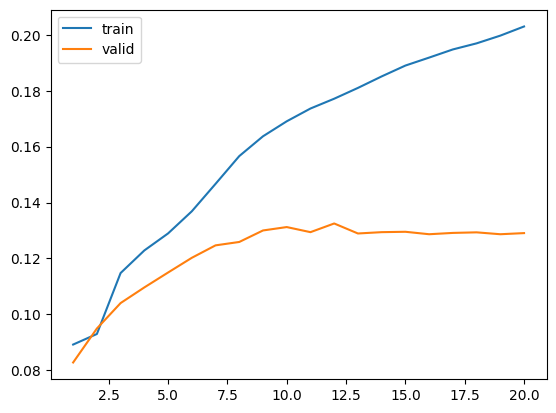

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [ ]:
pip install typing-extensions==4.6.0

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.6.0 which is incompatible.


In [ ]:
pip install kaleido


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 14.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
pip install --upgrade fastapi typing-extensions


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.6.0
    Uninstalling typing_extensions-4.6.0:
      Successfully uninstalled typing_extensions-4.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.8.0 which is incompatible.


In [ ]:
pip install typing-extensions==3.10.0.2


  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.8.0
    Uninstalling typing_extensions-4.8.0:
      Successfully uninstalled typing_extensions-4.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
sqlalchemy 2.0.23 requires typing-extensions>=4.2.0, but you have typing-extensions 3.10.0.2 which is incompatible.
arviz 0.15.1 requires typing-extensions>=4.1.0, but you have typing-extensions 3.10.0.2 which is incompatible.
chex 0.1.7 requires typing-extensions>=4.2.0; python_version < "3.11", but you have typing-extensions 3.10.0.2 which is incompatible.
fastapi 0.104.1 requires typing-extensions>=4.8.0, but you have typing-extensions 3.10.0.2 which is incompatible.
flax 0.7.5 requires typing-extensions

In [ ]:
pip install --upgrade gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.7/302.7 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 7.7 MB/s eta 0:00:00
  Using cached typing_extensions-4.8.0-py3-none-any.whl (31 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 12.1 MB/s eta 0:00:00
 

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [ ]:
!pip install tensorflow==2.6.0
!pip install keras==2.6.0
!pip install gradio==2.1.0  # Cambié la versión de Gradio

import gradio as gr
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Asegúrate de importar tus otras bibliotecas necesarias, como tokenizer y model

def model_response(human_text):
    # Tu código restante aquí
    encoded = tok.texts_to_sequences([human_text])[0]
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    y_hat = model.predict(encoded).argmax(axis=-1)

    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)


ERROR: Could not find a version that satisfies the requirement tensorflow==2.6.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0)
ERROR: No matching distribution found for tensorflow==2.6.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires keras<2.15,>=2.14.0, but you have 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 29.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.4/699.4 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 48.6 MB/s eta 0:00:00
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3354 sha256=c17dabe5ceb2c510883d86b17395dfd737afc9f3f3902289f7e63f994381eb4c
  Stored in directory: /root/.cache/pip/wheels/22/35/5e/088242cb16f309a4ff4e94ce97f1ef8a469983fdde92b45f50
Successfully built flask-cachebuster
  Attempting uninstall: gradio
    Found existing installation: gradio 4.7.1
    Uninstalling gradio-4.7.1:
      Successfully uninstalled gradio-4.7.1


TypeError: ignored

In [ ]:
!pip install tensorflow==2.5.0
!pip install keras==2.4.3
!pip install gradio==2.1.0

import gradio as gr
from keras.preprocessing.sequence import pad_sequences

# Asegúrate de importar tus otras bibliotecas necesarias, como tokenizer y model

def model_response(human_text):
    # Tu código restante aquí
    encoded = tok.texts_to_sequences([human_text])[0]
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    y_hat = model.predict(encoded).argmax(axis=-1)

    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)


In [ ]:
!pip install tensorflow==2.5.0
!pip install keras==2.4.3
!pip install gradio==2.1.0

import gradio as gr
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Asegúrate de importar tus otras bibliotecas necesarias, como tokenizer y model

def model_response(human_text):
    # Tu código restante aquí
    encoded = tok.texts_to_sequences([human_text])[0]
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    y_hat = model.predict(encoded).argmax(axis=-1)

    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

# Usa la extensión gr.Colab para ejecutar Gradio en Colab
iface.launch(share=True)


In [ ]:
!pip install tensorflow==2.5.0
!pip install keras==2.4.3
!pip install gradio==2.1.0

import gradio as gr
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Asegúrate de importar tus otras bibliotecas necesarias, como tokenizer y model

def model_response(human_text):
    # Tu código restante aquí
    encoded = tok.texts_to_sequences([human_text])[0]
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    y_hat = model.predict(encoded).argmax(axis=-1)

    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

# Usa la extensión gr.Colab para ejecutar Gradio en Colab
iface.launch(share=True)


In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

### 6 - Generación de secuencias nuevas

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='noticias\'t'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

### 7 - Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=3):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="when i find myself in times")

In [ ]:
# veamos las salidas
decode(salidas[0])

### 8 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.